<a href="https://colab.research.google.com/github/ndb796/Deep-Learning-Security-Basic-for-KISA/blob/master/Unrestricted_Attack_Using_GAN_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Unrestricted Attack Using GAN 실습**

* 본 실습에서는 Inception v3 모델을 공격 대상으로 설정하여 공격합니다.
  * **Targeted attack**: **까치(magpie)로 인식되는** 하나의 **얼룩 고양이(tabby cat)** 이미지를 만들어 봅시다.
  * **White-box attack**: 공격자가 공격 대상 모델의 **파라미터를 모두 알고 있다고** 가정합니다.
  * **Unrestricted attack**: 본 공격은 **노이즈(perturbation) 크기 제약이 없으며** 자연스러운 얼룩 고양이를 만드는 것을 목표로 합니다.
* **Pre-trained GAN**을 이용하여 현실적인 적대적 예제(adversarial example)를 만들 수 있습니다
  * **참고 논문 1)** Obfuscated Gradients Give a False Sense of Security: Circumventing Defenses to Adversarial Examples (ICML 2018)
    * 상기 논문에서는 생성자(generator)의 매니폴드 상에서도 충분히 적대적 예제가 존재할 수 있음을 입증합니다.
  * **참고 논문 2)** Constructing Unrestricted Adversarial Examples with Generative Models (NIPS 2018)
    * 상기 논문에서는 별도의 GAN 모델을 학습하여 공격을 수행할 수 있음을 보입니다.
  * **참고 논문 3)** Fine-grained Synthesis of Unrestricted Adversarial Examples (2019)
    * 상기 논문에서는 사전 학습된 GAN 모델을 이용해 높은 퀄리티의 적대적 예제를 만들 수 있음을 보입니다.
* 본 코드는 일반적으로 학습된 **(non-certified)** Inception v3 모델에 대한 공격을 실습합니다.
* 코드 실행 전에 **\[런타임\]** → **\[런타임 유형 변경\]** → 유형을 **GPU**로 설정합니다.

In [1]:
# 필요한 PyTorch 라이브러리 불러오기
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [2]:
# GPU 장치 사용 설정
device = torch.device("cuda")

#### **이미지넷(ImageNet)에 정의된 클래스 정보 가져오기**

In [3]:
from urllib.request import urlretrieve
import json

# 이미지넷(ImageNet)에 정의된 1,000개의 레이블(클래스) 정보 가져오기
imagenet_json, _ = urlretrieve('http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)

In [4]:
# 인덱스(index) 18에 해당하는 클래스는 까치(magpie)입니다.
print(imagenet_labels[18])

magpie


#### **이미지 처리 함수 정의 및 이미지 가져와 출력해보기**

* 공격 대상으로 설정한 Inception v3은 이미지에 대하여 **Resize**, **CenterCrop**, **ToTensor()**와 **입력 데이터 정규화**를 사용하는 모델입니다.
* 공격자는 이러한 사실을 이미 알고 있다고 가정(white-box)하며 공격용 이미지를 먼저 torch.Tensor 형태로 만듭니다.

In [5]:
imsize = 256

preprocess = transforms.Compose([
    transforms.Resize(imsize), # 이미지의 크기를 변경
    transforms.CenterCrop(imsize), # 이미지의 중앙 부분을 잘라서 크기 조절
    transforms.ToTensor(), # torch.Tensor 형식으로 변경 [0, 255] → [0, 1]
])

In [6]:
# 이미지(그림) 출력 관련 라이브러리
import matplotlib.pyplot as plt
import PIL

In [7]:
# 특정한 경로에서 이미지를 가져와 torch.Tensor로 변환하는 함수
def image_loader(path):
    image = PIL.Image.open(path)
    # 전처리 이후에 네트워크 입력에 들어갈 이미지에 배치 목적의 차원(dimension) 추가
    image = preprocess(image).unsqueeze(0)
    return image.to(device, torch.float) # GPU로 올리기

In [8]:
# 실제로 특정 URL에서 이미지를 불러오기 (얼룩 고양이)
url = "http://www.image-net.org/nodes/10/02123045/6c/6c34fe7c9d846c33a2f1a9b47a766b44ab4ec70d.thumb"
image_path, _ = urlretrieve(url)
image = image_loader(image_path)

In [9]:
# torch.Tensor 형태의 이미지를 화면에 출력하는 함수
def imshow(tensor):
    # matplotlib는 CPU 기반이므로 CPU로 옮기기
    image = tensor.cpu().clone()
    # torch.Tensor에서 사용되는 배치 목적의 차원(dimension) 제거
    image = image.squeeze(0)
    # PIL 객체로 변경 
    image = transforms.ToPILImage()(image)
    # 이미지를 화면에 출력(matplotlib는 [0, 1] 사이의 값이라고 해도 정상적으로 처리)
    plt.imshow(image)

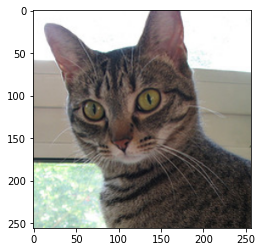

In [10]:
plt.figure()
imshow(image)

#### **사전 학습된(pretrained) Inception v3 모델을 불러와 사용해보기**

In [11]:
# 입력 데이터 정규화를 위한 클래스 정의
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [12]:
# 공격자가 가지고 있는 torch.Tensor 형식의 이미지 데이터는 입력 정규화를 거치기 전이므로, 정규화 이후에 모델에 넣도록 설정
classifier = nn.Sequential(
    # 기본적인 Inception v3와 동일한 동작을 위하여 정규화 레이어 추가
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
).to(device).eval() # 모델을 GPU로 옮기기 및 평가(테스트) 모드로 변경

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [13]:
# 기본적인 이미지를 실제 모델에 넣어 결과 확인
outputs = classifier(((generated + 1.0) / 2.0))
# 확률을 계산하기 위해 소프트맥스(softmax) 함수 취하기
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
# 가장 높은 값을 가지는 5개의 인덱스를 하나씩 확인하며
print("< 가장 높은 확률을 가지는 클래스들 >")
for i in outputs[0].topk(5)[1]:
    # 높은 값을 가지는 순서대로 인덱스에 해당하는 클래스 이름과, 그 확률 값 출력하기
    print(f"인덱스: {i.item()} / 클래스명: {imagenet_labels[i]} / 확률: {round(percentages[i].item(), 4)}%")

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 82.9564%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 14.9831%
인덱스: 282 / 클래스명: tiger cat / 확률: 2.0471%
인덱스: 840 / 클래스명: swab, swob, mop / 확률: 0.0011%
인덱스: 284 / 클래스명: Siamese cat, Siamese / 확률: 0.0008%


### **StyleGAN 라이브러리 불러오기**

In [14]:
!git clone https://github.com/pacifinapacific/StyleGAN_LatentEditor
%cd StyleGAN_LatentEditor

Cloning into 'StyleGAN_LatentEditor'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 167 (delta 70), reused 50 (delta 5), pack-reused 0
Receiving objects: 100% (167/167), 4.25 MiB | 44.45 MiB/s, done.
Resolving deltas: 100% (70/70), done.
/content/StyleGAN_LatentEditor


In [15]:
# PyTorch 버전의 StyleGAN 모델 (LSUN Cat 데이터셋) 다운로드
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXTU2qzMnEBAuIipuDqON2EBJd9UTw5JR5bcDJg6_BU8Pg?download=1 -O karras2019stylegan-cats-256x256.pt

--2020-10-22 08:11:45--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXTU2qzMnEBAuIipuDqON2EBJd9UTw5JR5bcDJg6_BU8Pg?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/karras2019stylegan-cats-256x256.pt?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FWFRVMnF6TW5FQkF1SWlwdURxT04yRUJKZDlVVHc1SlI1YmNESmc2X0JVOFBnP3J0aW1lPTk4elFIbUoyMkVn [following]
--2020-10-22 08:11:46--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/karras2019stylegan-cats-256x256.pt?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FW

### **StyleGAN 모델을 수정해 공격용으로 만들기**

* StyleGAN은 upsampling 과정에서 랜덤 노이즈(random noise)를 섞습니다.
* 랜덤 노이즈는 의도적으로 삽입한 perturbation의 기능을 약하게 만들기 때문에 제거할 필요가 있습니다.

In [16]:
from stylegan_layers import G_mapping, G_synthesis
from collections import OrderedDict

g_all = nn.Sequential(OrderedDict([
    ('g_mapping', G_mapping()),
    ('g_synthesis', G_synthesis(resolution=256))  
]))

g_all.load_state_dict(torch.load("karras2019stylegan-cats-256x256.pt", map_location=device))
g_all.eval()
g_all.to(device)

g_mapping, generator = g_all[0], g_all[1]
generator.use_noise = False

In [17]:
# 랜덤 노이즈 레이어를 Identity 레이어로 초기화
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [18]:
# 중간의 모든 노이즈 레이어의 기능을 비활성화하기
generator.blocks["4x4"].epi1.top_epi.noise = Identity()
generator.blocks["4x4"].epi2.top_epi.noise = Identity()
generator.blocks["8x8"].epi1.top_epi.noise = Identity()
generator.blocks["8x8"].epi2.top_epi.noise = Identity()
generator.blocks["16x16"].epi1.top_epi.noise = Identity()
generator.blocks["16x16"].epi2.top_epi.noise = Identity()
generator.blocks["32x32"].epi1.top_epi.noise = Identity()
generator.blocks["32x32"].epi2.top_epi.noise = Identity()
generator.blocks["64x64"].epi1.top_epi.noise = Identity()
generator.blocks["64x64"].epi2.top_epi.noise = Identity()
generator.blocks["128x128"].epi1.top_epi.noise = Identity()
generator.blocks["128x128"].epi2.top_epi.noise = Identity()
generator.blocks["256x256"].epi1.top_epi.noise = Identity()
generator.blocks["256x256"].epi2.top_epi.noise = Identity()

#### **사전 학습된(pretrained) 생성자(Generator) 모델을 사용해보기**

In [19]:
latent = torch.zeros((1, 18, 512), requires_grad=True, device=device)

# 가짜 이미지(fake image) 생성
synth_img = generator(latent)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


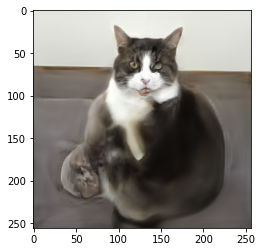

In [20]:
from PIL import Image
import matplotlib.pyplot as plt

# 초기 이미지 출력
plt.imshow(((synth_img + 1.0) / 2.0)[0].detach().cpu().squeeze(0).permute(1, 2, 0))
plt.show()

### **Attack 함수 정의**

In [28]:
import torch.optim as optim

# 공격 함수
def unrestricted_attack(generator, classifier, ori_label, trg_label, eps, alpha, iters):
    # 목표 레이블 데이터를 GPU로 옮기기
    trg_label = trg_label.to(device)

    # 임의의 latent vector와 perturbation 생성하기
    latent = torch.zeros((1, 18, 512), requires_grad=True, device=device)
    perturbation = torch.empty_like(latent).uniform_(-eps, eps)
    perturbation.to(device)

    # 손실(loss) 함수 설정
    attack_loss = nn.CrossEntropyLoss() # 목표 클래스로 분류되도록
    mse = torch.nn.MSELoss(reduction='sum') # 초기 이미지와 유사하도록

    # 시작 당시의 이미지 정보
    start_generated = generator(latent)

    print("[ 현재 이미지 ]")
    plt.imshow(((start_generated + 1.0) / 2.0)[0].detach().cpu().squeeze(0).permute(1, 2, 0))
    plt.show()

    for i in range(iters):
        # required_grad 속성의 값을 True로 설정하여 해당 torch.Tensor의 연산을 추적
        perturbation.requires_grad = True

        # 실제로 사용되는 latent vector 계산
        now = latent + perturbation

        # 모델에 입력하여 결과 계산
        generator.zero_grad()
        classifier.zero_grad()

        generated = generator(now)
        outputs = classifier((generated + 1.0) / 2.0)

        if i % 20 == 0:
            print(f"[ i = {i} ]")
            print("[ 현재 이미지 ]")
            plt.imshow(((generated + 1.0) / 2.0)[0].detach().cpu().squeeze(0).permute(1, 2, 0))
            plt.show()
            # 확률을 계산하기 위해 소프트맥스(softmax) 함수 취하기
            percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
            # 가장 높은 값을 가지는 3개의 인덱스를 하나씩 확인하며
            print("< 가장 높은 확률을 가지는 클래스들 >")
            for i in outputs[0].topk(3)[1]:
                # 높은 값을 가지는 순서대로 인덱스에 해당하는 클래스 이름과, 그 확률 값 출력하기
                print(f"인덱스: {i.item()} / 클래스명: {imagenet_labels[i]} / 확률: {round(percentages[i].item(), 4)}%")

        # 손실 함수에 대하여 미분하여 기울기(gradient) 계산
        cost = attack_loss(outputs, trg_label).to(device) * 1e3
        cost += mse(generated, start_generated).to(device)
        cost.backward(retain_graph=True) # 시작 이미지에 대한 기울기 정보는 유지(retain)될 수 있도록

        # 계산된 기울기(gradient)를 이용하여 손실 함수가 감소하는 방향으로 업데이트
        diff = - alpha * perturbation.grad.sign()
        perturbation = torch.clamp(perturbation + diff, min=-eps, max=eps).detach_()

    return latent, perturbation

#### **Target Attack 예시(Restricted)**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 현재 이미지 ]


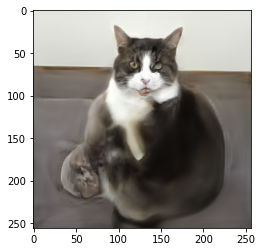

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 0 ]
[ 현재 이미지 ]


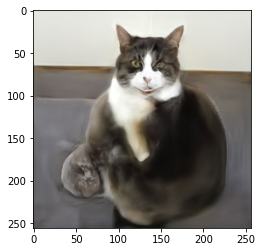

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 64.8265%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 31.0843%
인덱스: 282 / 클래스명: tiger cat / 확률: 3.7798%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 20 ]
[ 현재 이미지 ]


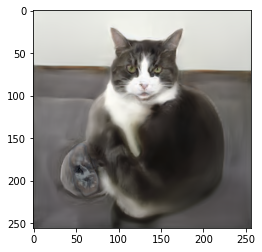

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 36.5234%
인덱스: 284 / 클래스명: Siamese cat, Siamese / 확률: 20.2119%
인덱스: 282 / 클래스명: tiger cat / 확률: 14.551%
[ i = 40 ]
[ 현재 이미지 ]


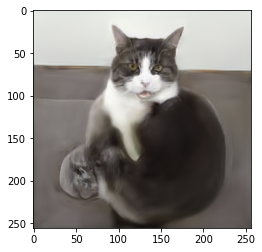

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 282 / 클래스명: tiger cat / 확률: 15.3469%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 11.1344%
인덱스: 909 / 클래스명: wok / 확률: 9.3946%
[ i = 60 ]
[ 현재 이미지 ]


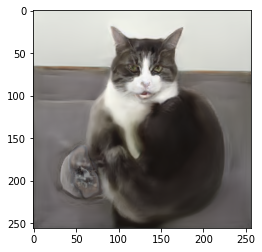

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 673 / 클래스명: mouse, computer mouse / 확률: 9.3252%
인덱스: 282 / 클래스명: tiger cat / 확률: 7.9957%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 6.1746%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 80 ]
[ 현재 이미지 ]


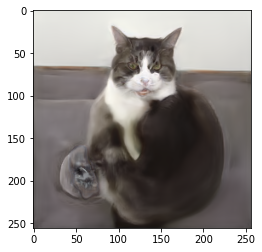

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 15.7769%
인덱스: 673 / 클래스명: mouse, computer mouse / 확률: 9.8554%
인덱스: 287 / 클래스명: lynx, catamount / 확률: 9.3871%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 100 ]
[ 현재 이미지 ]


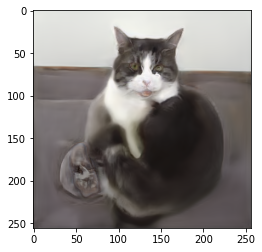

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 622 / 클래스명: lens cap, lens cover / 확률: 13.6321%
인덱스: 673 / 클래스명: mouse, computer mouse / 확률: 11.948%
인덱스: 940 / 클래스명: spaghetti squash / 확률: 6.8884%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 120 ]
[ 현재 이미지 ]


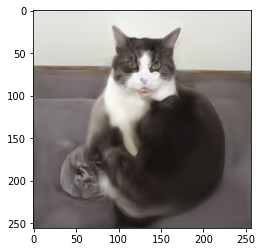

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 21.7899%
인덱스: 282 / 클래스명: tiger cat / 확률: 13.1301%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 7.3562%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 140 ]
[ 현재 이미지 ]


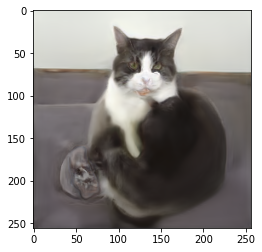

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 13.1684%
인덱스: 673 / 클래스명: mouse, computer mouse / 확률: 6.8791%
인덱스: 284 / 클래스명: Siamese cat, Siamese / 확률: 6.821%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 160 ]
[ 현재 이미지 ]


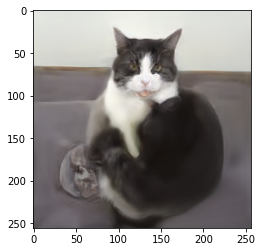

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 20.5593%
인덱스: 622 / 클래스명: lens cap, lens cover / 확률: 12.706%
인덱스: 377 / 클래스명: marmoset / 확률: 6.892%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 180 ]
[ 현재 이미지 ]


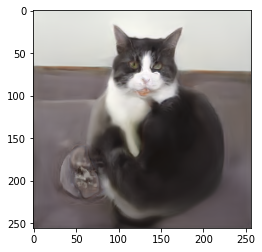

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 27.8387%
인덱스: 622 / 클래스명: lens cap, lens cover / 확률: 23.7065%
인덱스: 377 / 클래스명: marmoset / 확률: 3.2805%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 200 ]
[ 현재 이미지 ]


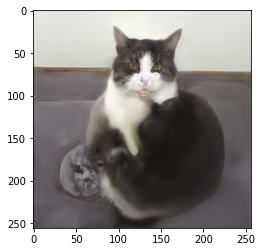

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 15.1236%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 9.4576%
인덱스: 722 / 클래스명: ping-pong ball / 확률: 7.0316%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 220 ]
[ 현재 이미지 ]


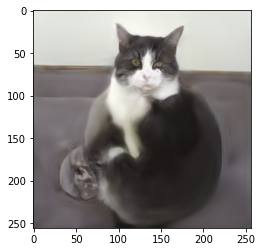

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 20.7114%
인덱스: 18 / 클래스명: magpie / 확률: 18.4866%
인덱스: 282 / 클래스명: tiger cat / 확률: 7.9093%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 240 ]
[ 현재 이미지 ]


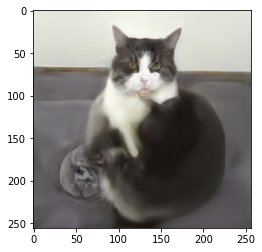

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 46.3483%
인덱스: 673 / 클래스명: mouse, computer mouse / 확률: 7.3576%
인덱스: 282 / 클래스명: tiger cat / 확률: 3.5362%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 260 ]
[ 현재 이미지 ]


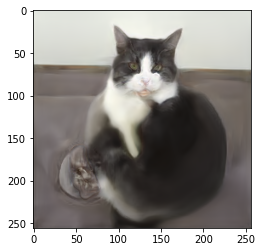

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 91.8265%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 0.8065%
인덱스: 435 / 클래스명: bathtub, bathing tub, bath, tub / 확률: 0.679%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 280 ]
[ 현재 이미지 ]


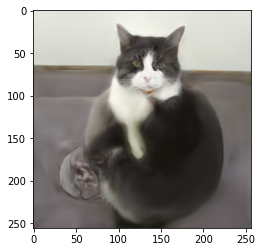

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 92.952%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 0.8848%
인덱스: 435 / 클래스명: bathtub, bathing tub, bath, tub / 확률: 0.8799%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 300 ]
[ 현재 이미지 ]


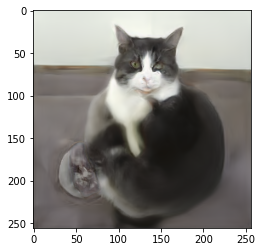

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 88.4142%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 1.659%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 1.2016%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 320 ]
[ 현재 이미지 ]


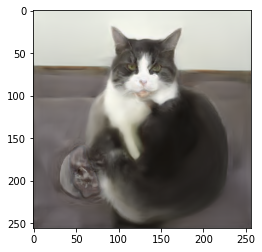

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 44.2883%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 8.6643%
인덱스: 282 / 클래스명: tiger cat / 확률: 7.5529%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 340 ]
[ 현재 이미지 ]


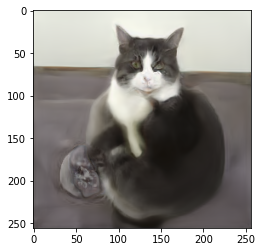

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 90.3283%
인덱스: 145 / 클래스명: king penguin, Aptenodytes patagonica / 확률: 0.8549%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 0.7597%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 360 ]
[ 현재 이미지 ]


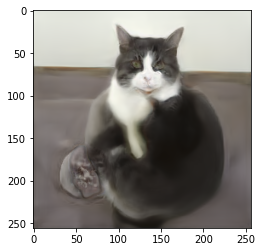

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 97.7849%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 0.2808%
인덱스: 435 / 클래스명: bathtub, bathing tub, bath, tub / 확률: 0.2638%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 380 ]
[ 현재 이미지 ]


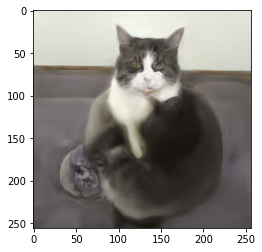

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 77.9219%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 3.6262%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 1.7496%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 400 ]
[ 현재 이미지 ]


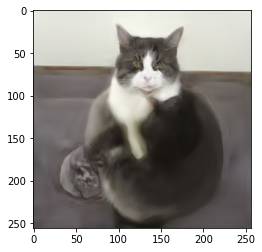

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 95.4049%
인덱스: 145 / 클래스명: king penguin, Aptenodytes patagonica / 확률: 0.8976%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 0.5851%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 420 ]
[ 현재 이미지 ]


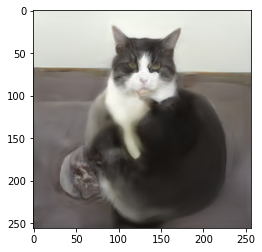

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 68.7267%
인덱스: 282 / 클래스명: tiger cat / 확률: 3.4129%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 3.0367%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 440 ]
[ 현재 이미지 ]


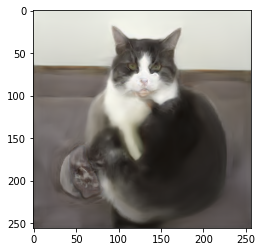

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 95.2791%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 0.5449%
인덱스: 282 / 클래스명: tiger cat / 확률: 0.5394%
[ i = 460 ]
[ 현재 이미지 ]


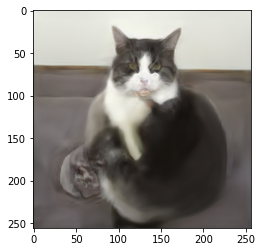

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 94.8569%
인덱스: 145 / 클래스명: king penguin, Aptenodytes patagonica / 확률: 0.5516%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 0.4808%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 480 ]
[ 현재 이미지 ]


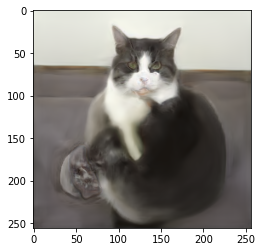

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 93.1915%
인덱스: 145 / 클래스명: king penguin, Aptenodytes patagonica / 확률: 0.9333%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 0.4377%


In [29]:
# 공격용 파라미터 설정
eps = 8/255
alpha = 0.5/255
iters = 500

# 얼룩 고양이(tabby cat)으로 보이도록 설정
ori_label = "tabby cat" # index: 281

# 까치(magpie)로 분류되도록 공격 수행
trg_label = [18]
trg_label = torch.Tensor(trg_label)
trg_label = trg_label.type(torch.long)

latent, perturbation = unrestricted_attack(generator, classifier, ori_label, trg_label, eps, alpha, iters)

In [33]:
generated = generator(latent + perturbation)

# 완성된 공격 이미지를 실제 모델에 넣어 결과 확인
outputs = classifier((generated + 1.0) / 2.0)
# 확률을 계산하기 위해 소프트맥스(softmax) 함수 취하기
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
# 가장 높은 값을 가지는 5개의 인덱스를 하나씩 확인하며
print("< 가장 높은 확률을 가지는 클래스들 >")
for i in outputs[0].topk(5)[1]:
    # 높은 값을 가지는 순서대로 인덱스에 해당하는 클래스 이름과, 그 확률 값 출력하기
    print(f"인덱스: {i.item()} / 클래스명: {imagenet_labels[i]} / 확률: {round(percentages[i].item(), 4)}%")

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 99.3105%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 0.0627%
인덱스: 145 / 클래스명: king penguin, Aptenodytes patagonica / 확률: 0.0589%
인덱스: 91 / 클래스명: coucal / 확률: 0.0441%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 0.0371%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


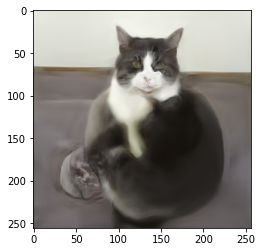

In [34]:
# 최종적으로 만들어진 공격 이미지 출력
plt.imshow(((generated + 1.0) / 2.0)[0].detach().cpu().squeeze(0).permute(1, 2, 0))
plt.show()